In [ ]:
## Inštalácia potrebných komponentov ##
## Nutné inštalovať každú zvlášť ##

pip install pydot
pip install git+https://github.com/tensorflow/examples.git
pip install graphviz
pip install opencv-python

In [50]:
## Načítanie potrebných knižníc ##

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [51]:
## Priradenie ciest k trénovacím, testovacím obrázkom a ich maskám ##
## V prípade trénovania na iné dáta, stačí zmeniť cestu priamo tu. Zvyšok kódu ostáva nezmenený ##

train_images_path = "/home/jovyan/work/bakalar_praca/scss-net/data/193_train/193(region_growth)/imgs/"
train_masks_path = "/home/jovyan/work/bakalar_praca/scss-net/data/193_train/193(region_growth)/masks/"
test_images_path = "/home/jovyan/work/bakalar_praca/scss-net/data/193_test/imgs/"
test_masks_path = "/home/jovyan/work/bakalar_praca/scss-net/data/193_test/masks/"

In [52]:
## Mapovanie štítkov do 3 kategorii (OUTPUT CLASSES = 3) ##

unique_labels = [
     0, 18, 54, 66, 43, 9, 40, 114, 185, 88, 2, 38, 177, 232, 254, 255, 248, 216,
     242, 237, 17, 11, 33, 178, 174, 133, 168, 63, 164, 241, 28, 8, 152, 214, 49, 16,
     192, 219, 14, 50, 244, 202, 68, 10, 153, 235, 190, 65, 64, 36, 52, 239, 176, 62,
     116, 209, 228, 106, 24, 167, 166, 238, 213, 208, 23, 51, 187, 15, 31, 206, 84, 224,
     245, 200, 247, 196, 105, 57, 173, 21, 136, 227, 108, 6, 205, 253, 160, 243, 218, 87,
     123, 59, 37, 55, 91, 29, 56, 128, 77, 231, 229, 110, 41, 230, 93, 79, 58
]

label_map = {
    0: 0}

class_counter = 0
for label in unique_labels:
    if label not in label_map:
        label_map[label] = class_counter
        class_counter = (class_counter + 1) % 3  

In [53]:
## Načítanie a úprava obrázkov ##

def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])  # Zmena veľkosti obrázku na 256x256
    image = tf.cast(image, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Zmena veľkosti masky na 256x256
  
      
    new_mask = tf.zeros_like(mask)
    for original_label, new_label in label_map.items():
        mask_of_label = tf.equal(mask, tf.constant(original_label, dtype=tf.uint8))
        new_mask = tf.where(mask_of_label, tf.constant(new_label, dtype=tf.uint8), new_mask)
        
    return image,new_mask

In [54]:
## Definícia vytvorenia datasetu ##

def create_dataset(image_paths, mask_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

In [55]:
## Vytvorenie ciest s jednotlivým dátam ##
## Pomocou definície create_dataset() sa vytvoria 3 datasety (trénovací a testovací a validačný, ktorý tvorí 20% z trénovacieho) ##

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    [os.path.join(train_images_path, file_name) for file_name in os.listdir(train_images_path) if os.path.isfile(os.path.join(train_images_path, file_name))],
    [os.path.join(train_masks_path, file_name) for file_name in os.listdir(train_masks_path) if os.path.isfile(os.path.join(train_masks_path, file_name))],
    test_size=0.2, random_state=42)

train_dataset = create_dataset(train_image_files, train_mask_files)
val_dataset = create_dataset(val_image_files, val_mask_files)
test_dataset = create_dataset(
    [os.path.join(test_images_path, file_name) for file_name in os.listdir(test_images_path) if os.path.isfile(os.path.join(test_images_path, file_name))],
    [os.path.join(test_masks_path, file_name) for file_name in os.listdir(test_masks_path) if os.path.isfile(os.path.join(test_masks_path, file_name))])

In [56]:
## Výpis počtu záznamov v trénovacej a testovacej množine ##

def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

num_train = count_files(train_images_path)
num_test = count_files(test_images_path)

print(f"Počet obrázkov v trénovacej množine: {num_train}")
print(f"Počet obrázkov v testovacej množine: {num_test}")

Počet obrázkov v trénovacej množine: 7872
Počet obrázkov v testovacej množine: 353


In [57]:
## Definovanie dôležitých parametrov trénovania ##

OUTPUT_CLASSES = 3
BATCH_SIZE = 80
STEPS_PER_EPOCH = len(train_image_files) // BATCH_SIZE
VALIDATION_STEPS = len(val_image_files) // BATCH_SIZE

In [58]:
## Augmentácia trénovacích dát horizontálnym otočením ##

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [59]:
## Spracovanie trénovacích, validačných a testovacích dát ##


train_batches = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
val_batches = val_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [60]:
## Nastavenie vizualizácie obrázkov pri trénovaní/testovaní ##

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [62]:
## Vytvorenie a konfigurácia základného modelu ###

base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [63]:
## Up-sampling, ktoré sa používa na zväčšenie priestorových rozmerov dát pri segmentácii obrazu ##

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [64]:
## Definovanie a vytvorenie modelu U-net ##

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[256,256, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])


    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate() 
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
## Spracovanie predikovaných masiek ##

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [66]:
## Definovanie zobrazenia výsledkov predikcií ##

def show_predictions(dataset=None, num=4):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [67]:
## Definovanie vizuálneho zobrazenia výstupu pri trénovaní ##

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        
        for images, masks in train_batches.take(1):
            pred_mask = model.predict(images)
            print("Shape of Predicted Mask:", pred_mask.shape)
            print("Shape of True Mask:", masks.shape)
        
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [68]:
## Výpis informácii o modeli ##

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           [(None, 128, 128, 9  1841984     ['input_6[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

3/3 [==============================] - 3s 955ms/step
Shape of Predicted Mask: (80, 256, 256, 3)
Shape of True Mask: (80, 256, 256, 1)
1/1 [==============================] - 0s 67ms/step


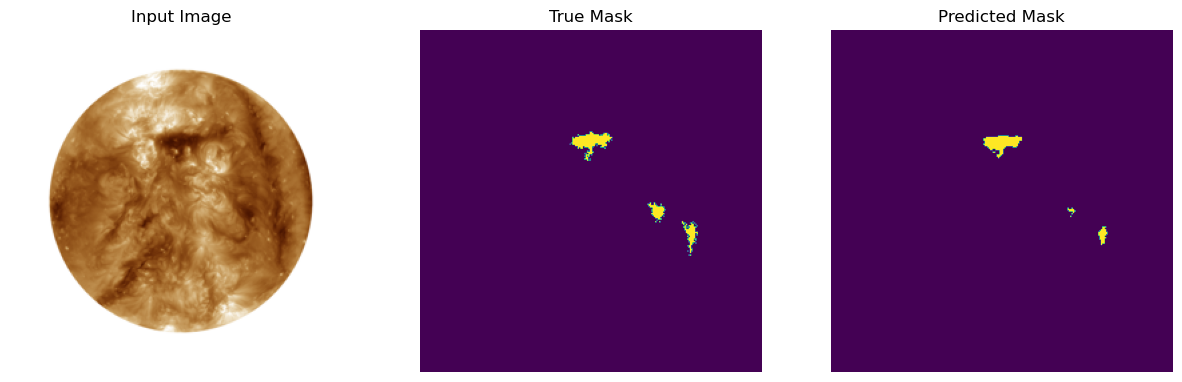


Sample Prediction after epoch 20

78/78 [==============================] - 403s 5s/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.0222 - val_accuracy: 0.9924


In [69]:
## Trénovanie modelu ##

EPOCHS = 20

model_history = model.fit(
    train_batches, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[DisplayCallback()]  
)

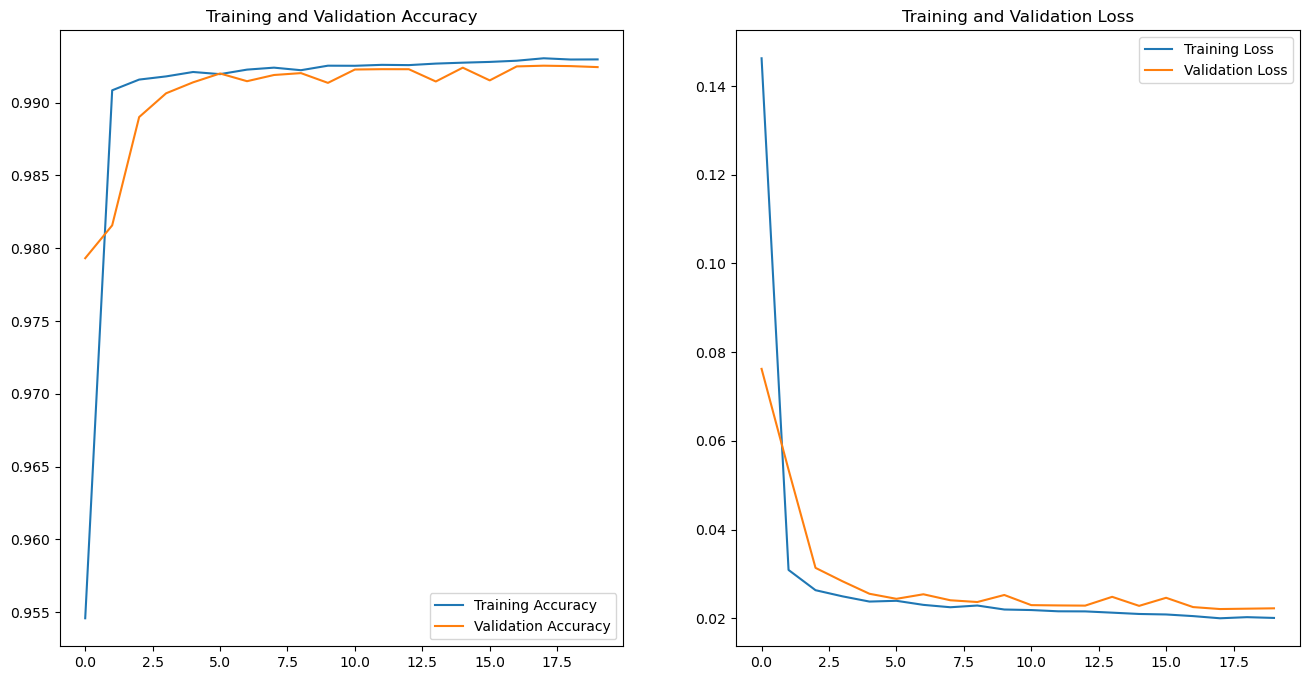

In [71]:
# Vytvorenie grafov na zobrazenenie Validačnej a Trénovacej Presnosti/Straty počas trénovania

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_metrics(model_history)

In [72]:
## Definovanie logiky namapovania predikovanej masky na pôvodný obrázok ##

def create_overlay(image, pred_mask, true_mask=None, alpha=0, contour_thickness = 1):
    image = np.uint8(image * 255)
    
    pred_mask = np.squeeze(pred_mask)  
    color_mask = np.zeros_like(image, dtype=np.uint8)
    
    overlay = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    
    if contour_thickness > 0:
        contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), contour_thickness)

    return overlay

In [73]:
## Definovanie IoU a Dice skóre ##

def iou_score(true, pred):
    pred = tf.math.argmax(pred, axis=-1)
    pred = tf.expand_dims(pred, axis=-1)
    true = tf.cast(true, tf.bool)
    pred = tf.cast(pred, tf.bool)
    intersection = tf.logical_and(true, pred)
    union = tf.logical_or(true, pred)
    intersection = tf.cast(intersection, tf.float32)
    union = tf.cast(union, tf.float32)
    iou = tf.reduce_sum(intersection) / tf.reduce_sum(union)
    return iou.numpy()

def dice_score(true, pred):
    pred = tf.math.argmax(pred, axis=-1)
    pred = tf.expand_dims(pred, axis=-1)
    true = tf.cast(true, tf.bool)
    pred = tf.cast(pred, tf.bool)
    intersection = tf.logical_and(true, pred)
    intersection = tf.cast(intersection, tf.float32)
    dice = (2 * tf.reduce_sum(intersection)) / (tf.reduce_sum(tf.cast(true, tf.float32)) + tf.reduce_sum(tf.cast(pred, tf.float32)))
    return dice.numpy()

3/3 [==============================] - 3s 939ms/step


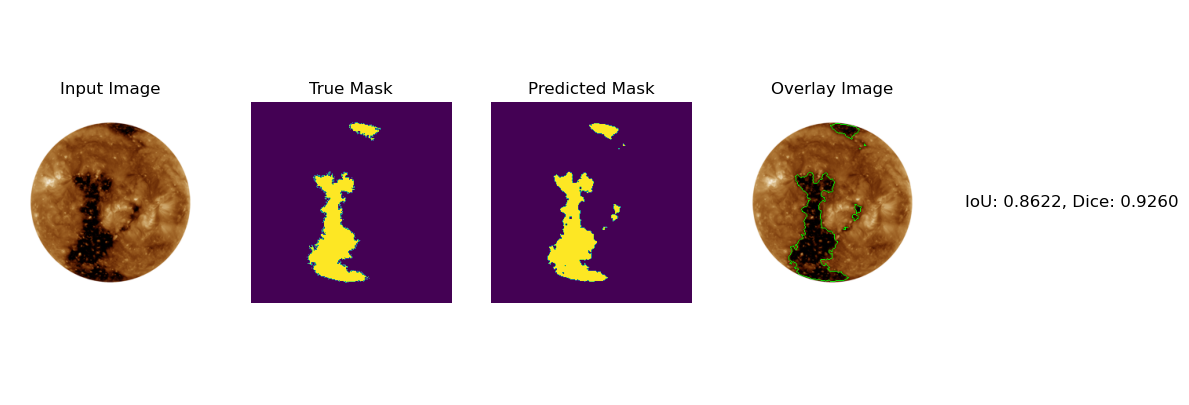

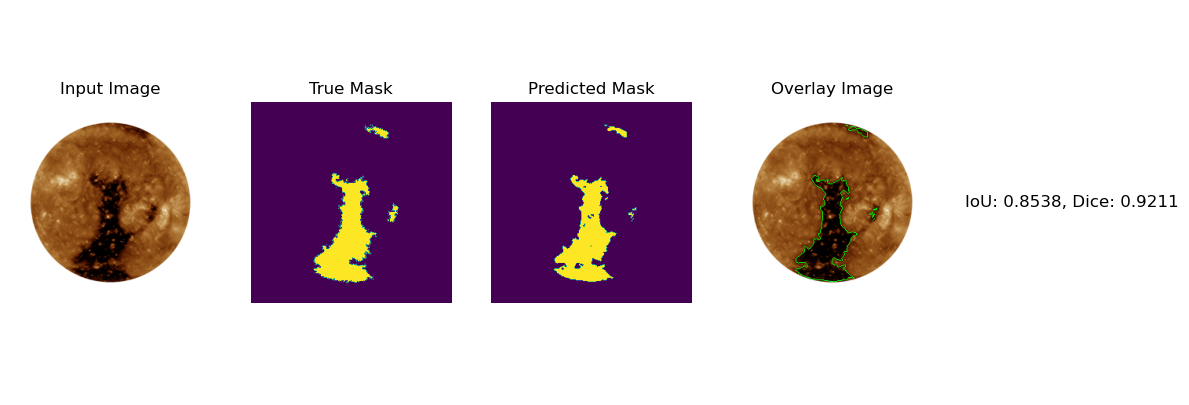

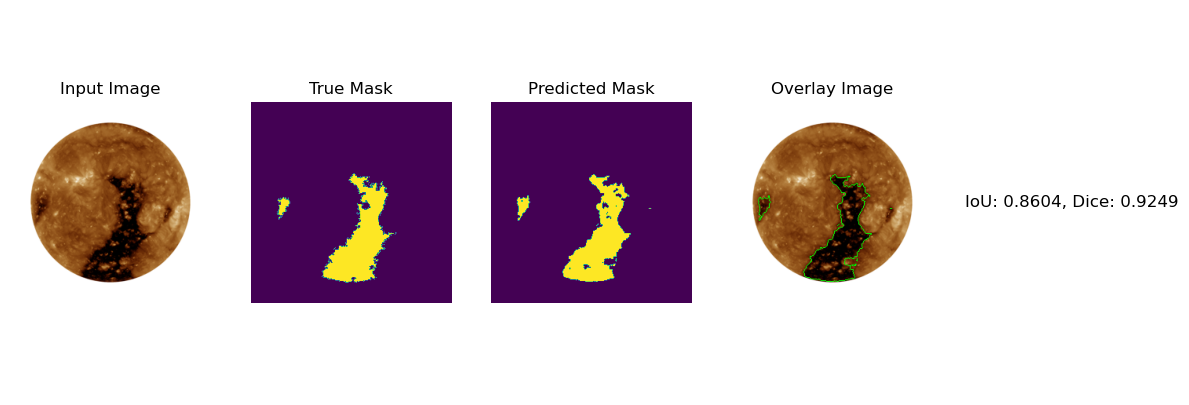

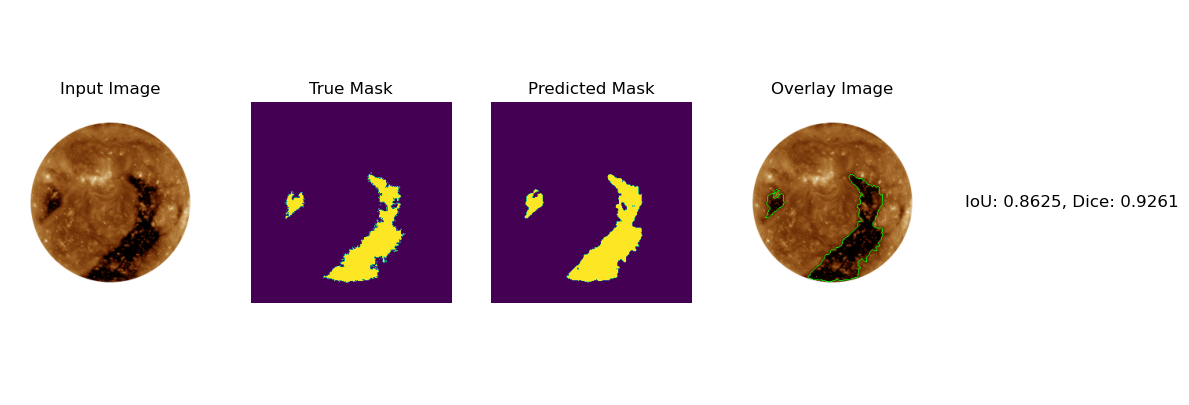

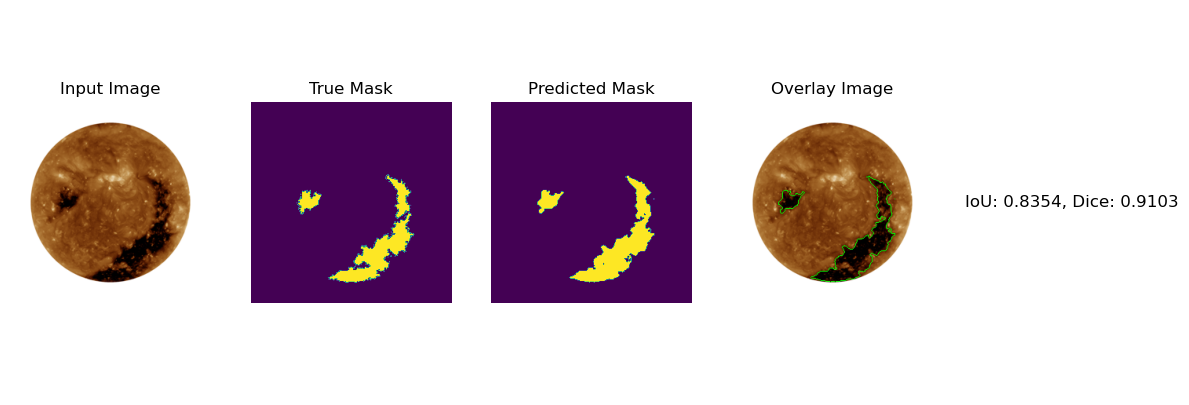

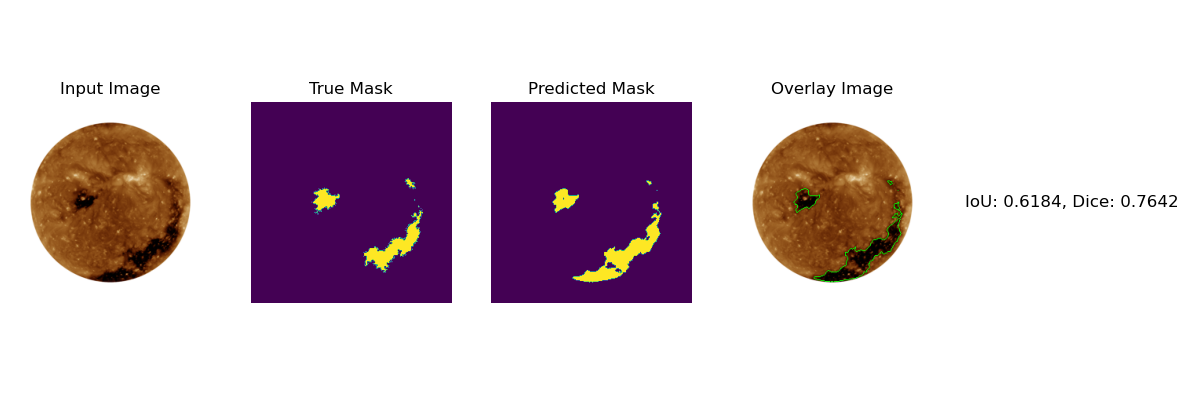

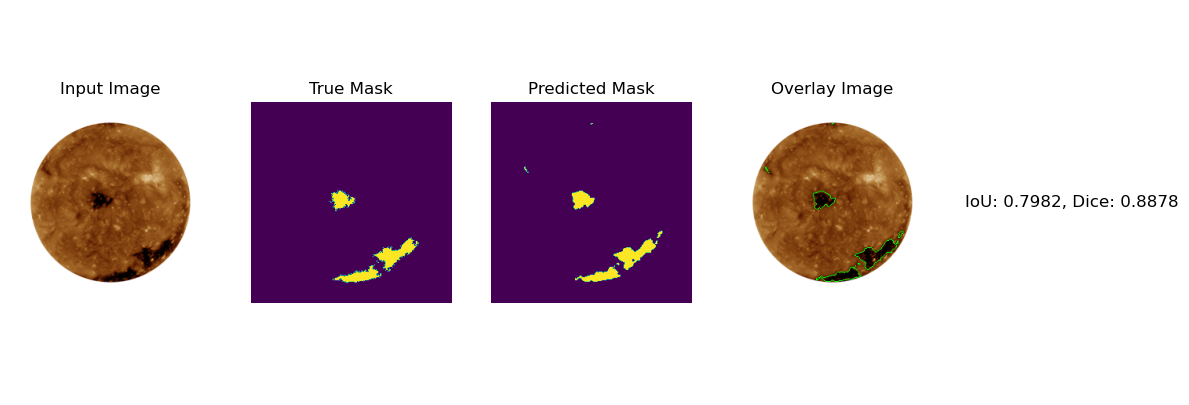

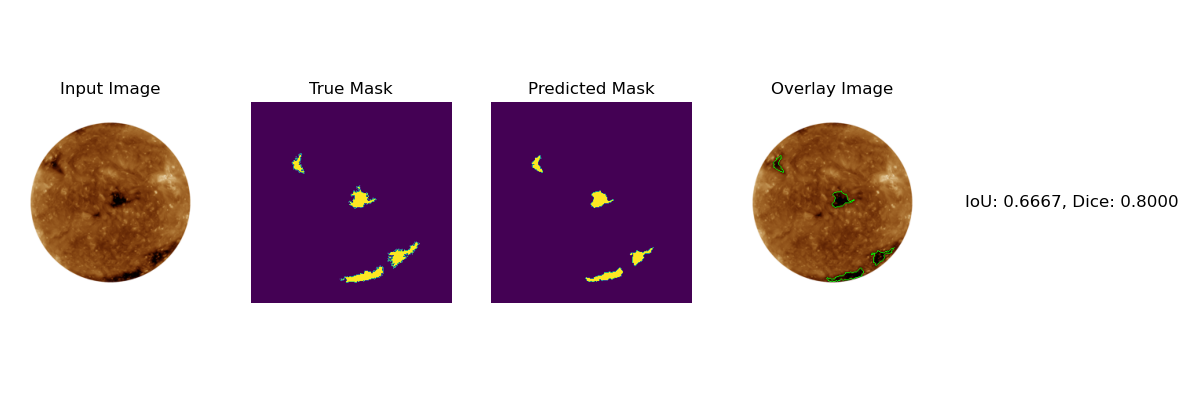

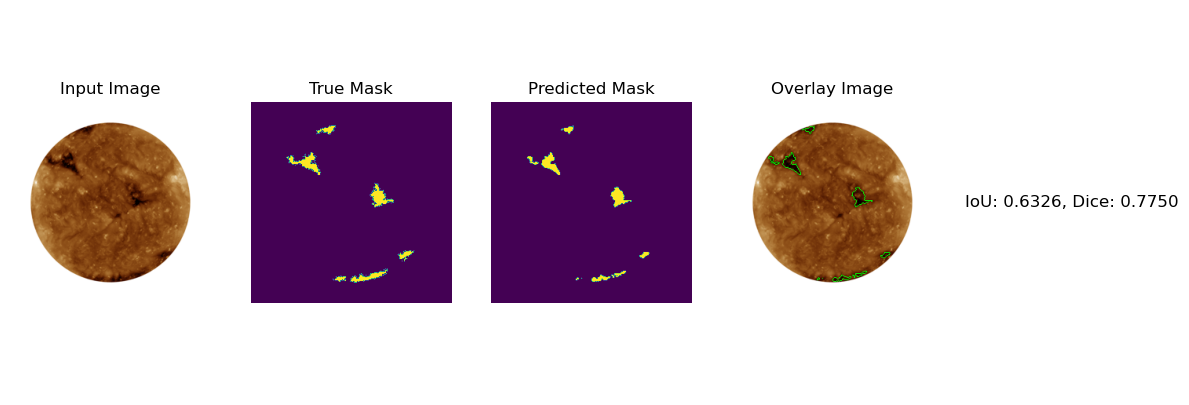

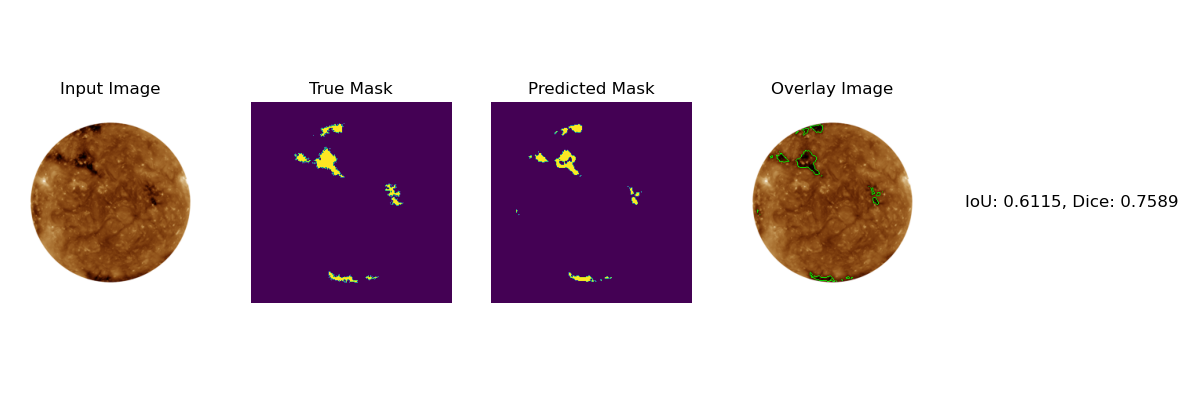

Average IoU over 10 predictions: 0.7602
Average Dice over 10 predictions: 0.8594


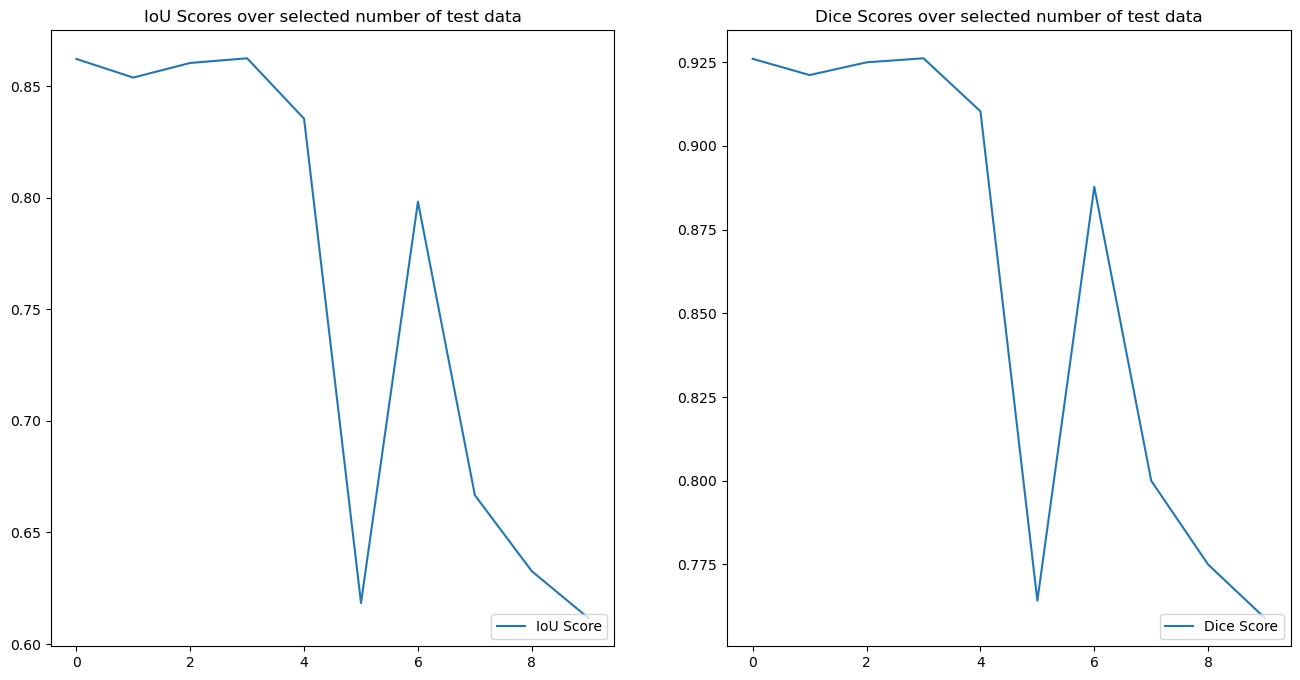

In [77]:
## Zobrazenie num=x  počtu predikcií z testovacej množiny s grafom o priebehu metrík. Taktiež vypočíta priemernú hodnotu metrík zobrazeného počtu výsledkov ##

def show_predictions(dataset, num=10):
    displayed = 0
    total_iou = 0
    total_dice = 0
    iou_scores = []
    dice_scores = []
    
    for images, masks in dataset:
        if displayed >= num:
            break

        pred_masks = model.predict(images)
        for i in range(len(images)):
            if displayed >= num:
                break
            
            pred_mask = create_mask(pred_masks[i:i+1])
            overlay = create_overlay(images[i].numpy(), pred_mask.numpy(), masks[i].numpy())
            
            iou = iou_score(masks[i:i+1], pred_masks[i:i+1])
            dice = dice_score(masks[i:i+1], pred_masks[i:i+1])
            
            iou_scores.append(iou)
            dice_scores.append(dice)
            
            total_iou += iou
            total_dice += dice
            
            display_list = [images[i], masks[i], pred_mask, overlay]
            titles = ['Input Image', 'True Mask', 'Predicted Mask', 'Overlay Image']
            metrics_text = f'IoU: {iou:.4f}, Dice: {dice:.4f}'
            
            plt.figure(figsize=(15, 5))
            for j in range(len(display_list)):
                plt.subplot(1, len(display_list) + 1, j+1)
                plt.title(titles[j])
                plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[j]))
                plt.axis('off')
            
            plt.subplot(1, len(display_list) + 1, len(display_list) + 1).axis('off')
            plt.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
            
            plt.show()
            
            displayed += 1

    if displayed > 0:
        avg_iou = total_iou / displayed
        avg_dice = total_dice / displayed
        print(f'Average IoU over {displayed} predictions: {avg_iou:.4f}')
        print(f'Average Dice over {displayed} predictions: {avg_dice:.4f}')
    else:
        print("No predictions were made.")
    
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(iou_scores)), iou_scores, label='IoU Score')
    plt.legend(loc='lower right')
    plt.title('IoU Scores over selected number of test data')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(dice_scores)), dice_scores, label='Dice Score')
    plt.legend(loc='lower right')
    plt.title('Dice Scores over selected number of test data')
    plt.show()

show_predictions(test_batches)

In [ ]:
## Uloženie natrénovaného modelu ##

model.save('/home/jovyan/work/bakalar_praca/scss-net/data/model_full_saved_full')

In [70]:
## Načítanie natrénovaného modelu ##

model = tf.keras.models.load_model('/home/jovyan/work/bakalar_praca/scss-net/data/model_full_saved_full')